In [1]:
# Much of the structure for this code, more specifically the data pre-processing, was taken from https://www.kaggle.com/looc60/birdsong-recognition-model-input-comparison/data#Introduction

# We then built upon the data pre-processing and implemented our own version of the convolutional neural network

In [2]:
# imports
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# imports
import librosa
import librosa.display
import IPython.display as ipd

In [4]:
# more imports (csv data)
train_csv = pd.read_csv("/Users/tesfashenkute/Downloads/birdsong-recognition/train.csv")
test_csv = pd.read_csv("/Users/tesfashenkute/Downloads/birdsong-recognition/test.csv")

/Users/tesfashenkute/opt/miniconda3/envs/myenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (1,2,3,4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,26,27,28,29,30,31,32,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# checking the data
train_csv.head
test_csv.head

<bound method NDFrame.head of      site                                      row_id  seconds  \
0  site_1   site_1_0a997dff022e3ad9744d4e7bbf923288_5        5   
1  site_1  site_1_0a997dff022e3ad9744d4e7bbf923288_10       10   
2  site_1  site_1_0a997dff022e3ad9744d4e7bbf923288_15       15   

                           audio_id  
0  0a997dff022e3ad9744d4e7bbf923288  
1  0a997dff022e3ad9744d4e7bbf923288  
2  0a997dff022e3ad9744d4e7bbf923288  >

In [6]:
# Narrowing down bird species to save on computational power
# Narrowing down to aldfly, dowwoo and hamfly

train_data = pd.DataFrame()

for row in range(train_csv.shape[0]) :
    for name in ['aldfly','dowwoo', 'hamfly'] :
        if train_csv.iloc[row]['ebird_code'] == name :
            train_data = train_data.append(train_csv.iloc[row])

In [7]:
# building audio data path
main_dir = '/Users/tesfashenkute/Downloads/birdsong-recognition/train_audio'
train_data['full_path'] = main_dir + '/' + train_csv['ebird_code'] + '/' + train_data['filename']


In [8]:
# setting audio data according to bird species code (SAMPLE)
aldfly = train_data[train_data['ebird_code'] == "aldfly"].sample(1, random_state = 33)['full_path'].values[0]
dowwoo = train_data[train_data['ebird_code'] == "dowwoo"].sample(1, random_state = 33)['full_path'].values[0]
hamfly = train_data[train_data['ebird_code'] == "hamfly"].sample(1, random_state = 33)['full_path'].values[0]

In [9]:
print(aldfly)
print(dowwoo)
print(hamfly)

/Users/tesfashenkute/Downloads/birdsong-recognition/train_audio/aldfly/XC195541.wav
/Users/tesfashenkute/Downloads/birdsong-recognition/train_audio/dowwoo/XC360351.wav
/Users/tesfashenkute/Downloads/birdsong-recognition/train_audio/hamfly/XC294468.wav


In [10]:
# Checking audio samples

In [11]:
aldfly_audio_sample = librosa.load(aldfly)

In [12]:
dowwoo_audio_sample = librosa.load(dowwoo)

In [13]:
hamfly_audio_sample = librosa.load(hamfly)

In [8]:
# Generating STFT

import json 
import os
import math
import librosa
import warnings
import numpy as np
warnings.simplefilter("ignore")

DATASET_PATH = "/Users/tesfashenkute/Downloads/birdsong-recognition/train_audio/"
JSON_PATH = "STFT.json"
SAMPLE_RATE = 22050

TO_PROCESS = ["aldfly", "dowwoo","hamfly"] # Species we want to process (decreases computational time im on a macbook pro lol)

# parameters changes because STFTs are much more memory-consuming than MFCCs
def save_stft(dataset_path, json_path, n_fft=512, hop_length=2048, segment_duration=4): 
    """Extracts STFTs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save STFTs
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and STFTs
    data = {
        "mapping": [], # genres
        "labels": [], # a number (corresponding to a genres) : targets that we expect
        "stft": [] # will bbe the inputs
    }
    
    file_count = 0 # keeps teack of the loading process

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split('/')[-1]
            
            # Proceed to data extraction only for few species
            if semantic_label in TO_PROCESS:
                
                # Keeps track of loading process
                file_count = file_count + 1
            
                data["mapping"].append(semantic_label)
                print("\nProcessing: {}".format(semantic_label))

                # process all audio files in genre sub-dir
                
                num_file = 0
                for f in filenames:
                    num_file += 1
                    
                    # audio file
                    file_path = os.path.join(dirpath, f)
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE) # audio file in array

                    audio_duration = librosa.get_duration(signal, sr=SAMPLE_RATE) # different duration for each sample
                    num_segments = int(audio_duration // segment_duration) # number of segments the audio can be cut into
                    # we want audios of the same duration to allow comparisons

                    samples_per_segment = int(SAMPLE_RATE * segment_duration)
                    num_stft_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
                    # that will be what we study

                    
                    # print("{}, segment:{}".format(file_path, d+1), end = '\r', flush=True)
                    print("processing file {} on {}, folder {} on {}".format(num_file,len(filenames),file_count,len(TO_PROCESS)))
                    
                    # process all segments of audio file
                    for d in range(num_segments):

                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d  # sample at which the segment begin
                        finish = start + samples_per_segment # sample at which the segment stops

                        # extract stft (what we will use)
                        stft = np.abs(librosa.stft(signal[start:finish], 
                                                    n_fft=n_fft, 
                                                    hop_length=hop_length))
                        stft = librosa.amplitude_to_db(stft, ref = np.max)
                        stft = stft.T


                        # store only stft feature with expected number of vectors
                        if len(stft) == num_stft_vectors_per_segment: 
                            data["stft"].append(stft.tolist())
                            data["labels"].append(i-1)


    # save STFTs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent = 4)
        print("Data successfully saved !")  

# Function execution
save_stft(DATASET_PATH, JSON_PATH, segment_duration=6)


Processing: hamfly
processing file 1 on 100, folder 1 on 3
processing file 2 on 100, folder 1 on 3
processing file 3 on 100, folder 1 on 3
processing file 4 on 100, folder 1 on 3
processing file 5 on 100, folder 1 on 3
processing file 6 on 100, folder 1 on 3
processing file 7 on 100, folder 1 on 3
processing file 8 on 100, folder 1 on 3
processing file 9 on 100, folder 1 on 3
processing file 10 on 100, folder 1 on 3
processing file 11 on 100, folder 1 on 3
processing file 12 on 100, folder 1 on 3
processing file 13 on 100, folder 1 on 3
processing file 14 on 100, folder 1 on 3
processing file 15 on 100, folder 1 on 3
processing file 16 on 100, folder 1 on 3
processing file 17 on 100, folder 1 on 3
processing file 18 on 100, folder 1 on 3
processing file 19 on 100, folder 1 on 3
processing file 20 on 100, folder 1 on 3
processing file 21 on 100, folder 1 on 3
processing file 22 on 100, folder 1 on 3
processing file 23 on 100, folder 1 on 3
processing file 24 on 100, folder 1 on 3
proce

In [2]:
# Generating MFCC

import json 
import os
import math
import librosa
import warnings
warnings.simplefilter("ignore")

DATASET_PATH = "/Users/tesfashenkute/Downloads/birdsong-recognition/train_audio/"
JSON_PATH = "MFCC.json"
SAMPLE_RATE = 22050

TO_PROCESS = ["aldfly", "dowwoo","hamfly"] # Species we want to process (decreases computational time im on a macbook pro lol)

# main function
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, segment_duration=6):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [], # genres
        "labels": [], # a number (corresponding to a genres) : targets that we expect
        "mfcc": [] # will bbe the inputs
    }
    

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split('/')[-1]
            
            # Proceed to data extraction only for few species
            if semantic_label in TO_PROCESS:
            
                data["mapping"].append(semantic_label)
                print("\nProcessing: {}".format(semantic_label))

                # process all audio files in genre sub-dir
                
                num_file = 0
                for f in filenames:
                    num_file += 1
                    
                    # audio file
                    file_path = os.path.join(dirpath, f)
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE) # audio file in array

                    audio_duration = librosa.get_duration(signal, sr=SAMPLE_RATE) # different duration for each sample
                    num_segments = int(audio_duration // segment_duration) # number of segments the audio can be cut into
                    # we want audios of the same duration to allow comparisons

                    samples_per_segment = int(SAMPLE_RATE * segment_duration)
                    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
                    # that will be what we study

                    # process all segments of audio file
                    for d in range(num_segments):

                        # calculate start and finish sample for current segment
                        start = samples_per_segment * d  # sample at which the segment begin
                        finish = start + samples_per_segment # sample at which the segment stops

                        # extract mfcc (what we will use)
                        mfcc = librosa.feature.mfcc(signal[start:finish], 
                                                    sample_rate, 
                                                    n_mfcc=num_mfcc, 
                                                    n_fft=n_fft, 
                                                    hop_length=hop_length)
                        mfcc = mfcc.T


                        # store only mfcc feature with expected number of vectors
                        if len(mfcc) == num_mfcc_vectors_per_segment: 
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            # print("{}, segment:{}".format(file_path, d+1), end = '\r', flush=True)
                            print("processing file {} on {}".format(num_file,len(filenames)), end = '\r', flush=True)

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent = 4)
        print("Data successfully saved !")       

# Function execution
save_mfcc(DATASET_PATH, JSON_PATH, segment_duration=6)


Processing: hamfly

Processing: dowwoo

Processing: aldfly
Data successfully saved !


In [14]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow.keras as keras
import time

In [15]:
DATA_PATH_MFCC = "MFCC.json"
DATA_PATH_STFT = "STFT.json"
np.random.seed(42)

In [16]:
# Loading data set from json file

def load_data(data_path,data_type):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    # Convert lists to numpy arrays
    X = np.array(data[data_type])
    y = np.array(data["labels"])

    print("Data loaded.")
    
    # Resetting indexes
    values = list(set(y))
    
    for i in range(len(values)):
        y[y == values[i]] = i
        
    # returns the inputs to be split in the following function
    return  X, y

In [19]:
def prepare_datasets(dataset, test_size, validation_size):
    if (dataset == "MFCC"):
        # loading MFCC data to inputs using load_data
        X, y = load_data(DATA_PATH_MFCC,"mfcc")
    
    if (dataset == "STFT"):
        # loading STFT data to inputs using load_data
        X, y = load_data(DATA_PATH_STFT,"stft")    

    # splitting test, training and validation data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # returning test, training and validation split
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [20]:
def add_axis(X_train, X_validation, X_test):
    # building inputs from new axis

    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    return X_train, X_validation, X_test

In [21]:
# Building final data

print("Building final dataset..")

# we will be using MFCC data as the reference and STFT to compare
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets("MFCC", 0.25, 0.2)
X2_train, X2_validation, X2_test, y2_train, y2_validation, y2_test = prepare_datasets("STFT", 0.25, 0.2)

print("Dataset built successfully")

Building final dataset..
Data loaded.
Data loaded.
Dataset built successfully


In [22]:
# Convolutional Neural Network
# Will attempt using input layer, 3 convolutional layers (all with relu activation function) and an output layer

In [23]:
# This code will build the CNN model for our training
def cnn_build(input_shape, output_shape):
    
    # initializing network
    cnn_model = keras.Sequential()

    # Layer 1
    cnn_model.add(keras.layers.Conv2D(64, (4, 4), activation='relu', input_shape=input_shape))
    cnn_model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    cnn_model.add(keras.layers.BatchNormalization())

    # Layer 2
    cnn_model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    cnn_model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    cnn_model.add(keras.layers.BatchNormalization())

    # Layer 3
    cnn_model.add(keras.layers.Conv2D(64, (2, 2), activation='relu', input_shape=input_shape))
    cnn_model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    cnn_model.add(keras.layers.BatchNormalization())

    # Inputting into output layer (flattening -> dense)
    cnn_model.add(keras.layers.Flatten())
    cnn_model.add(keras.layers.Dense(64, activation='relu'))
    cnn_model.add(keras.layers.Dropout(0.5))

    # Output
    cnn_model.add(keras.layers.Dense(output_shape, activation='softmax'))

    return cnn_model


In [24]:
# setting output parameter and labels

birds = ["aldfly", "dowwoo","hamfly"]
output_shape = len(birds)

In [25]:
### Add new axis to inputs for CNN ###
X_train_new, X_validation_new, X_test_new = add_axis(X_train, X_validation, X_test)
X2_train_new, X2_validation_new, X2_test_new = add_axis(X2_train, X2_validation, X2_test)

In [26]:
### CONVOLUTIONAL MODEL (MFCCs) ###
print("\n\n\tCONVOLUTIONAL MODEL (MFCCs)\n")

time_start = time.process_time()

    # Store shape of the input data (3-tuple)
input_shape = (X_train_new.shape[1], X_train_new.shape[2], 1)

    # create network
print("Creating network...")
model_conv = cnn_build(input_shape, output_shape)
print("Network created !\n")

    # compile model
print("Compiling Network...")
optimiser = keras.optimizers.Adam(learning_rate=0.0001) # Adam optimizer
model_conv.compile(optimizer=optimiser,
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
print("Network compiled !")

print("\nConvolutional model summary :")
model_conv.summary()

    # train model
print("\nTraining model...")
history_conv = model_conv.fit(X_train_new, y_train, validation_data=(X_validation_new, y_validation), batch_size=32, epochs=30)
print("Model is trained !\n")

    # evaluate model on test set
print("Evaluating model...")
test_loss_conv, test_acc_conv = model_conv.evaluate(X_test_new, y_test, verbose=2)
print('Test accuracy :', test_acc_conv)

    # Calculate computational time
time_conv = (time.process_time() - time_start)
print("\nComputational time of convolutional NN :", time_conv, "seconds")



	CONVOLUTIONAL MODEL (MFCCs)

Creating network...
Network created !

Compiling Network...
Network compiled !

Convolutional model summary :
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 10, 64)       1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 5, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 5, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 3, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 2, 32)

In [53]:

# Takes in training history of model and outputs graph of train and test accuracy and error rates

def plot_model_results(history):
    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch Number")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error")

    plt.show()
    

In [54]:
# Takes in trained model, input data, output and list of birds to generate a confusion matrix

def plot_confusion(model, X, y, labels):   
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    
    cm = confusion_matrix(y, predicted_index, normalize='true')


    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(include_values=True,
                 cmap='cividis')

    axes = plt.gca()
    axes.xaxis.set_ticklabels(labels, fontsize = 10, verticalalignment = 'center')
    axes.yaxis.set_ticklabels(labels, fontsize = 10, verticalalignment = 'center', rotation = 90)
    plt.show()

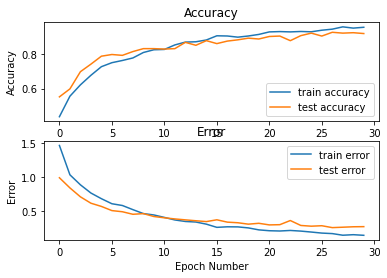

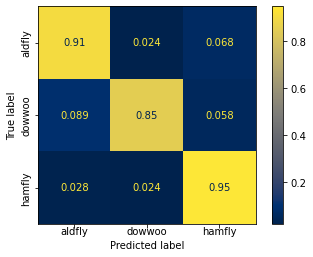

In [55]:
plot_model_results(history_conv)
plot_confusion(model_conv, X_test_new, y_test, birds)